1. Loading Dataset

In [1]:
import pandas as pd
df = pd.read_csv('/content/heart.csv')
print(df.shape)
print(df.head())
print(df.info())

(1025, 14)
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   52    1   0       125   212    0        1      168      0      1.0      2   
1   53    1   0       140   203    1        0      155      1      3.1      0   
2   70    1   0       145   174    0        1      125      1      2.6      0   
3   61    1   0       148   203    0        1      161      0      0.0      2   
4   62    0   0       138   294    1        1      106      0      1.9      1   

   ca  thal  target  
0   2     3       0  
1   0     3       0  
2   0     3       0  
3   1     3       0  
4   3     2       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null 

2. Quick EDA and Preprocessing

In [3]:
df.isnull().sum()
X = df.drop('target', axis=1)
y = df['target']
X = pd.get_dummies(X, drop_first=True)

3. Training/testing split

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

4. Baseline decision tree

In [5]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [6]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9853658536585366
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       100
           1       1.00      0.97      0.99       105

    accuracy                           0.99       205
   macro avg       0.99      0.99      0.99       205
weighted avg       0.99      0.99      0.99       205

[[100   0]
 [  3 102]]


5. Visualizing the decision tree

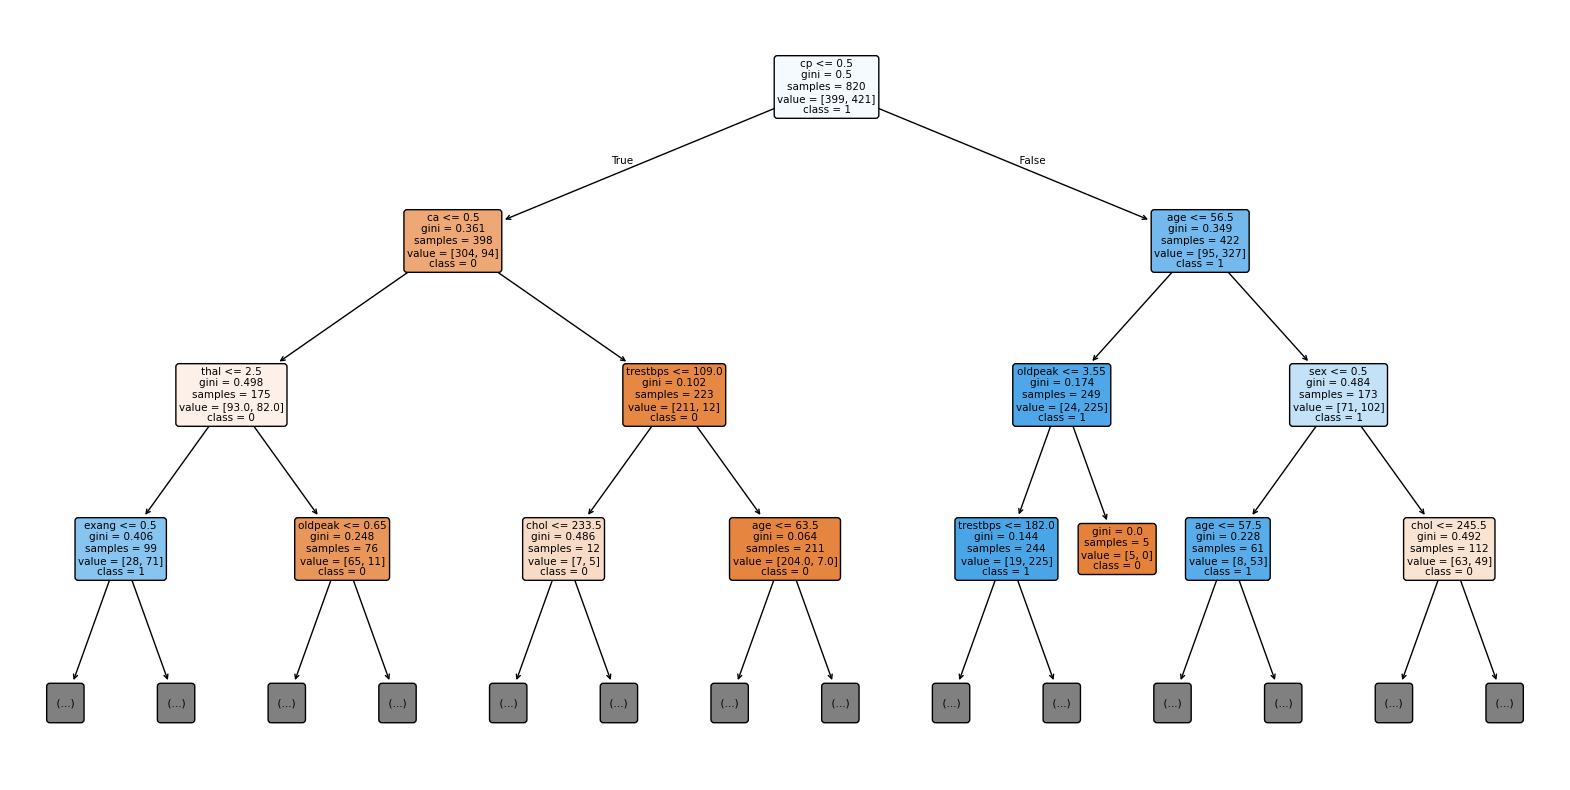

In [8]:
import matplotlib.pyplot as plt
from sklearn import tree
import os

# Create the directory if it doesn't exist
if not os.path.exists('figures'):
    os.makedirs('figures')

plt.figure(figsize=(20,10))
tree.plot_tree(clf, feature_names=X.columns, class_names=['0','1'], filled=True, rounded=True, max_depth=3)
plt.savefig('figures/decision_tree_top3.png', bbox_inches='tight')

6. Checking for overfitting

In [9]:
from sklearn.model_selection import validation_curve
import numpy as np

param_range = [1,2,3,4,5,6,8,10,12]
train_scores, val_scores = validation_curve(
    DecisionTreeClassifier(random_state=42),
    X_train, y_train,
    param_name='max_depth',
    param_range=param_range,
    cv=5, scoring='accuracy'
)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

7. Control overfitting

In [10]:
from sklearn.model_selection import GridSearchCV

param_grid = {
  'max_depth':[3,4,5,6,8,None],
  'min_samples_split':[2,5,10],
  'min_samples_leaf':[1,2,4],
  'ccp_alpha':[0.0, 0.001, 0.01]
}
grid = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
print(grid.best_params_, grid.best_score_)
best_tree = grid.best_estimator_

{'ccp_alpha': 0.0, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2} 0.9865853658536585


8. Training a random forest and comparing

In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1, oob_score=True)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

print('RF accuracy:', accuracy_score(y_test, y_pred_rf))
print('RF oob score (train):', getattr(rf, 'oob_score_', None))

RF accuracy: 1.0
RF oob score (train): 0.9926829268292683


Comparing with cross-validated scores :

In [12]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
import numpy as np
scores_tree = cross_val_score(best_tree, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
scores_rf   = cross_val_score(rf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print('Tree CV mean ± std:', np.mean(scores_tree), np.std(scores_tree))
print('RF   CV mean ± std:', np.mean(scores_rf), np.std(scores_rf))

Tree CV mean ± std: 1.0 0.0
RF   CV mean ± std: 0.9960975609756098 0.007804878048780495


9. Feature importance and interpretation

1. cp: 0.1448
2. thalach: 0.1181
3. ca: 0.1110
4. oldpeak: 0.1056
5. thal: 0.1018
6. age: 0.0918
7. chol: 0.0766
8. exang: 0.0742
9. trestbps: 0.0712
10. slope: 0.0452


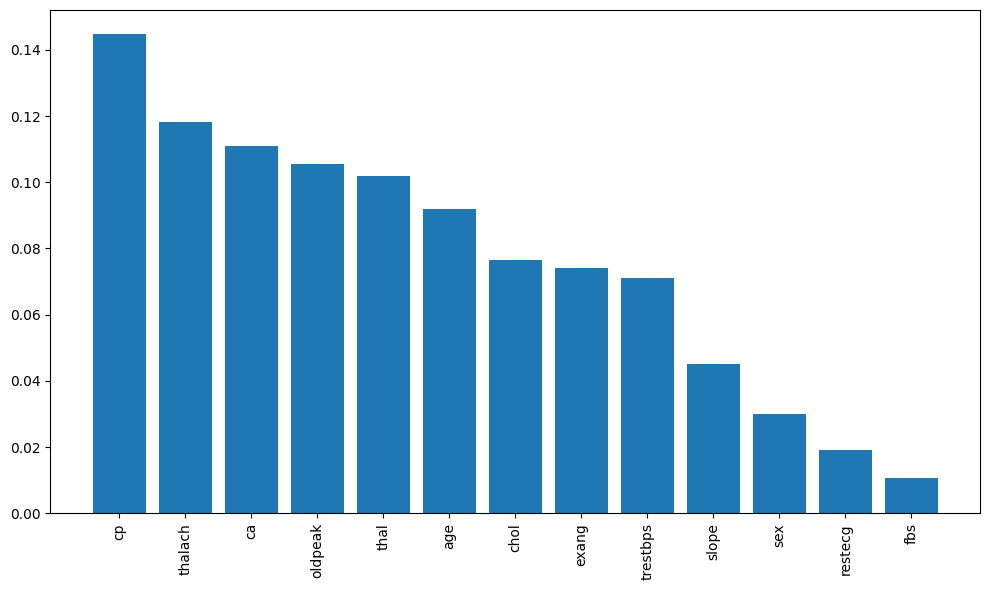

In [13]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

for i in range(min(10, X.shape[1])):
    print(f"{i+1}. {X.columns[indices[i]]}: {importances[indices[i]]:.4f}")

plt.figure(figsize=(10,6))
plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [X.columns[i] for i in indices], rotation=90)
plt.tight_layout()
plt.savefig('figures/feature_importances.png')

10. ROC/AUC

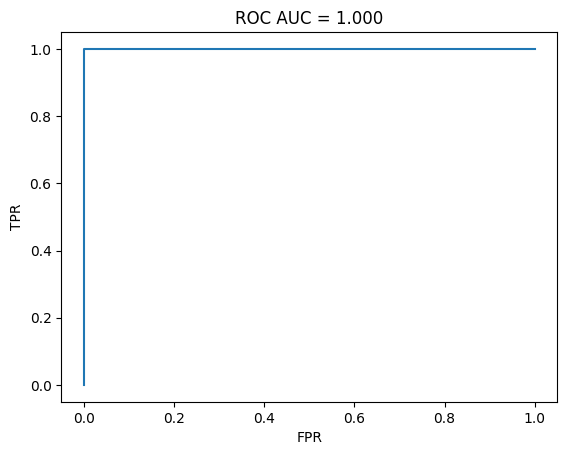

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve
y_proba = rf.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_proba)
fpr,tpr,_ = roc_curve(y_test, y_proba)

plt.figure()
plt.plot(fpr, tpr)
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title(f'ROC AUC = {auc:.3f}')
plt.savefig('figures/roc.png')

In [16]:
import joblib
import os

# Create the directory if it doesn't exist
if not os.path.exists('models'):
    os.makedirs('models')

joblib.dump(rf, 'models/random_forest.pkl')
joblib.dump(best_tree, 'models/best_tree.pkl')

['models/best_tree.pkl']